In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import nltk                                         #Natural language processing tool-kit

from nltk.corpus import stopwords                   #Stopwords corpus
from nltk.stem import PorterStemmer                 # Stemmer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec  

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import datetime
import string
import xgboost as xgb
import spacy
from spacy import displacy

from textblob import TextBlob 
import warnings
warnings.filterwarnings('ignore')
import pickle
import re
from datetime import timedelta
import pyLDAvis
import pyLDAvis.sklearn

In [1]:
import os, json
import pandas as pd
from datetime import datetime

path_to_json = './test_file'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
print(json_files)  # for me this prints ['foo.json']


call_df = pd.DataFrame()
calls_list = []
# we need both the json and an index number so use enumerate()
for index, js in enumerate(json_files):
    ticker = js.strip('.json')
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        for call_id in json_text['title'].keys():
            call_body = ' | '.join(map(str, json_text['body'][call_id]))
            call_date = datetime.fromtimestamp(
                    json_text['date'][call_id]/1000).strftime(
                            "%A, %B %d, %Y %I:%M:%S")
            calls_list.append([ticker, call_id, 
                                           json_text['title'][call_id], 
                                           call_date,
                                           call_body])

blob = pd.DataFrame(calls_list, 
                    columns=['ticker', 'call_id', 'title', 'date', 'body'])

['A.json', 'AAL.json', 'AAP.json', 'AAPL.json', 'ABC.json', 'ABT.json', 'ACN.json', 'ADBE.json', 'ADI.json', 'ADP.json', 'ADS.json', 'ADSK.json', 'AEE.json', 'AES.json', 'AGN.json', 'AIG.json', 'AIV.json', 'AJG.json', 'ALB.json', 'ALK.json', 'ALL.json', 'ALLE.json', 'ALXN.json', 'AMD.json', 'AME.json', 'AMG.json', 'AMGN.json', 'AMZN.json', 'ANSS.json', 'ANTM.json', 'AON.json', 'AOS.json', 'APA.json', 'APH.json', 'ARNC.json', 'ATVI.json', 'AVB.json', 'AVY.json', 'AWK.json', 'AXP.json', 'AZO.json', 'BA.json', 'BAC.json', 'BAX.json', 'BBY.json', 'BDX.json', 'BEN.json', 'BIIB.json', 'BK.json', 'BLK.json', 'BMY.json', 'BSX.json', 'BXP.json', 'C.json', 'CA.json', 'CAH.json', 'CAT.json', 'CBOE.json', 'CCL.json', 'CELG.json', 'CF.json', 'CFG.json', 'CHD.json', 'CHRW.json', 'CHTR.json', 'CI.json', 'CINF.json', 'CL.json', 'CMA.json', 'CME.json', 'CMG.json', 'CMS.json', 'CNC.json', 'COF.json', 'COG.json', 'COL.json', 'COO.json', 'COP.json', 'COST.json', 'COTY.json', 'CPB.json', 'CRM.json', 'CSX.j

In [3]:
blob.to_csv("blob1.csv")

In [4]:
bb = blob["call_id"]

In [5]:
bb.to_csv('bb.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [2]:
def preprocess(text):
    tokenized_list = text.split()
    # Get the stop words from nltk
    stopword = nltk.corpus.stopwords.words('english')# All English Stopwords
    ps = nltk.PorterStemmer()
    wn = nltk.WordNetLemmatizer()
    
    text = [wn.lemmatize(ps.stem(word)) for word in tokenized_list if word not in stopword]# To remove all stopwords
    
    return " ".join(text)

In [4]:

blob["datetime"] = blob["date"].apply(lambda x: pd.to_datetime(x))
blob['time'] = blob['datetime'].apply(lambda x: x.time())
blob['date'] =  blob['datetime'].apply(lambda x: x.date())

In [5]:
blob["body"] = blob["body"].apply(lambda x: preprocess(re.sub(r"^.+?(?=Operator)", "", x)
                              .lower()
                              .replace("operator", "")
                              .translate(str.maketrans('', '', string.punctuation))))

Sentiment

In [6]:
def get_polarity(text):
    try:
        pol = TextBlob(text).sentiment.polarity
    except:
        pol = 0.0
    return pol

In [7]:
blob['polarity'] = blob['body'].apply(lambda x: get_polarity(x) )

Merging

In [12]:
leadlag = pd.read_csv('datadict.csv')

In [13]:
final = blob.merge(leadlag, how='left', on='ticker')

In [21]:
test_feature= final[['sich', 'total_assets', 'Rdiff_lag1', 'Rdiff_lag2',
       'Rdiff_lag5', 'Rdiff_lead1', 'Rdiff_lead2', 'Rdiff_lead5', 'polarity']]

# test_feature = test_feature[feature_Set1.Rdiff_lag1 != "#NAME?"]
# test_feature['Rdiff_lag1'] = test_feature['Rdiff_lag1'].apply(lambda x: float(x))
# test_feature['Rdiff_lag2'] = test_feature['Rdiff_lag2'].apply(lambda x: float(x))
# test_feature['Rdiff_lag5'] = test_feature['Rdiff_lag5'].apply(lambda x: float(x))
# test_feature['Rdiff_lead1'] = test_feature['Rdiff_lead1'].apply(lambda x: float(x))
# test_feature['Rdiff_lead2'] = test_feature['Rdiff_lead2'].apply(lambda x: float(x))

test_feature.head()

,sich,total_assets,Rdiff_lag1,Rdiff_lag2,Rdiff_lag5,Rdiff_lead1,Rdiff_lead2,Rdiff_lead5,polarity
0,3826.0,9044.800000,0.146512,-1.000000,-1.596715,-1.927065,-0.986227,-0.669586,0.153183
1,3826.0,9044.800000,0.146512,-1.000000,-1.596715,-1.927065,-0.986227,-0.669586,0.123232
2,4512.0,33447.941180,-0.861627,-1.099721,-0.898527,-0.746586,-0.757239,-0.759973,0.159327
3,4512.0,33447.941180,-0.861627,-1.099721,-0.898527,-0.746586,-0.757239,-0.759973,0.167988
4,5531.0,4250.065471,-0.558059,-0.798714,-1.533903,-2.214566,-0.612456,0.624078,0.134625


In [22]:
train_features = pd.read_csv("feature_Set1.csv")

In [23]:
X_train, y_train = train_features[['sich', 'total_assets', 'Rdiff_lag1', 'Rdiff_lag2',
       'Rdiff_lag5', 'Rdiff_lead1', 'Rdiff_lead2', 'Rdiff_lead5', 'polarity']], train_features['Returns']

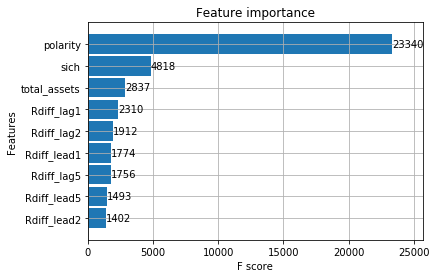

In [24]:
clf = xgb.XGBRegressor(n_estimators=1000)
clf.fit(X_train, y_train,
    eval_set=[(X_train, y_train)],
    early_stopping_rounds=80, #stop if 50 consequent rounds without decrease of error
    verbose=False)
xgb.plot_importance(clf, height=0.9)

In [25]:
y_pred = clf.predict(test_feature)
y_pred

array([ 2.37287283e-02,  4.68641222e-02,  2.43073702e-03, -2.76175141e-02,
       -2.58129835e-03,  2.37644017e-02, -1.70334578e-02,  2.15135515e-02,
       -9.27942991e-03,  3.09431851e-02,  2.38488615e-02,  2.71693170e-02,
        4.59016263e-02,  4.52580452e-02,  2.75629461e-02,  4.23249900e-02,
        8.52472186e-02, -1.28270507e-01,  8.22484493e-04,  1.79879665e-02,
        4.01709378e-02,  2.18145549e-02,  3.85068655e-02, -1.53529644e-03,
        8.56190920e-04, -1.97237730e-03,  1.14498734e-02, -1.30546093e-03,
        8.42931867e-03, -5.82665205e-03,  2.34960914e-02,  3.98395061e-02,
       -4.45407629e-02, -1.41835213e-03,  4.96432781e-02, -3.28153968e-02,
        5.69374561e-02,  8.07062387e-02, -4.08750772e-03, -1.18547082e-02,
        2.37587094e-02, -3.78412604e-02, -1.32201910e-02,  2.41913199e-02,
        2.35023201e-02, -9.30005312e-03, -7.97535777e-02,  2.26719081e-02,
        2.98410654e-03,  1.52466297e-02, -1.04075670e-02, -7.03477859e-03,
        1.09000802e-02, -

In [26]:
y_pred.shape

(654,)

In [27]:
np.savetxt("predictions.csv", y_pred, delimiter=",")